# Project Introduction

Digital Education in India is increasing day by day with advancement of web-based learning services, specifically, eLearning platforms. Rise of new digital technology also brings new chalanges. Digital classrooms are conducted via video telephony software program (ex-Zoom) where it’s not possible to see all students and access the mood. Students are not focusing on content due to lack of surveillance, but this challenge can be overcome by applying deep learning algorithms to live video data.

The solution to this problem is by recognizing the face, mark the attendance, log the individual’s
session time and put a drowsiness alert.


## Face Recognition

Face recognition algorithms can extract features from a face image namely positions of forehead, eyes, nose, mouth, chin, jaws. 

Face Landmarks – There are 68 specific points (called landmarks) that exist on every face. 



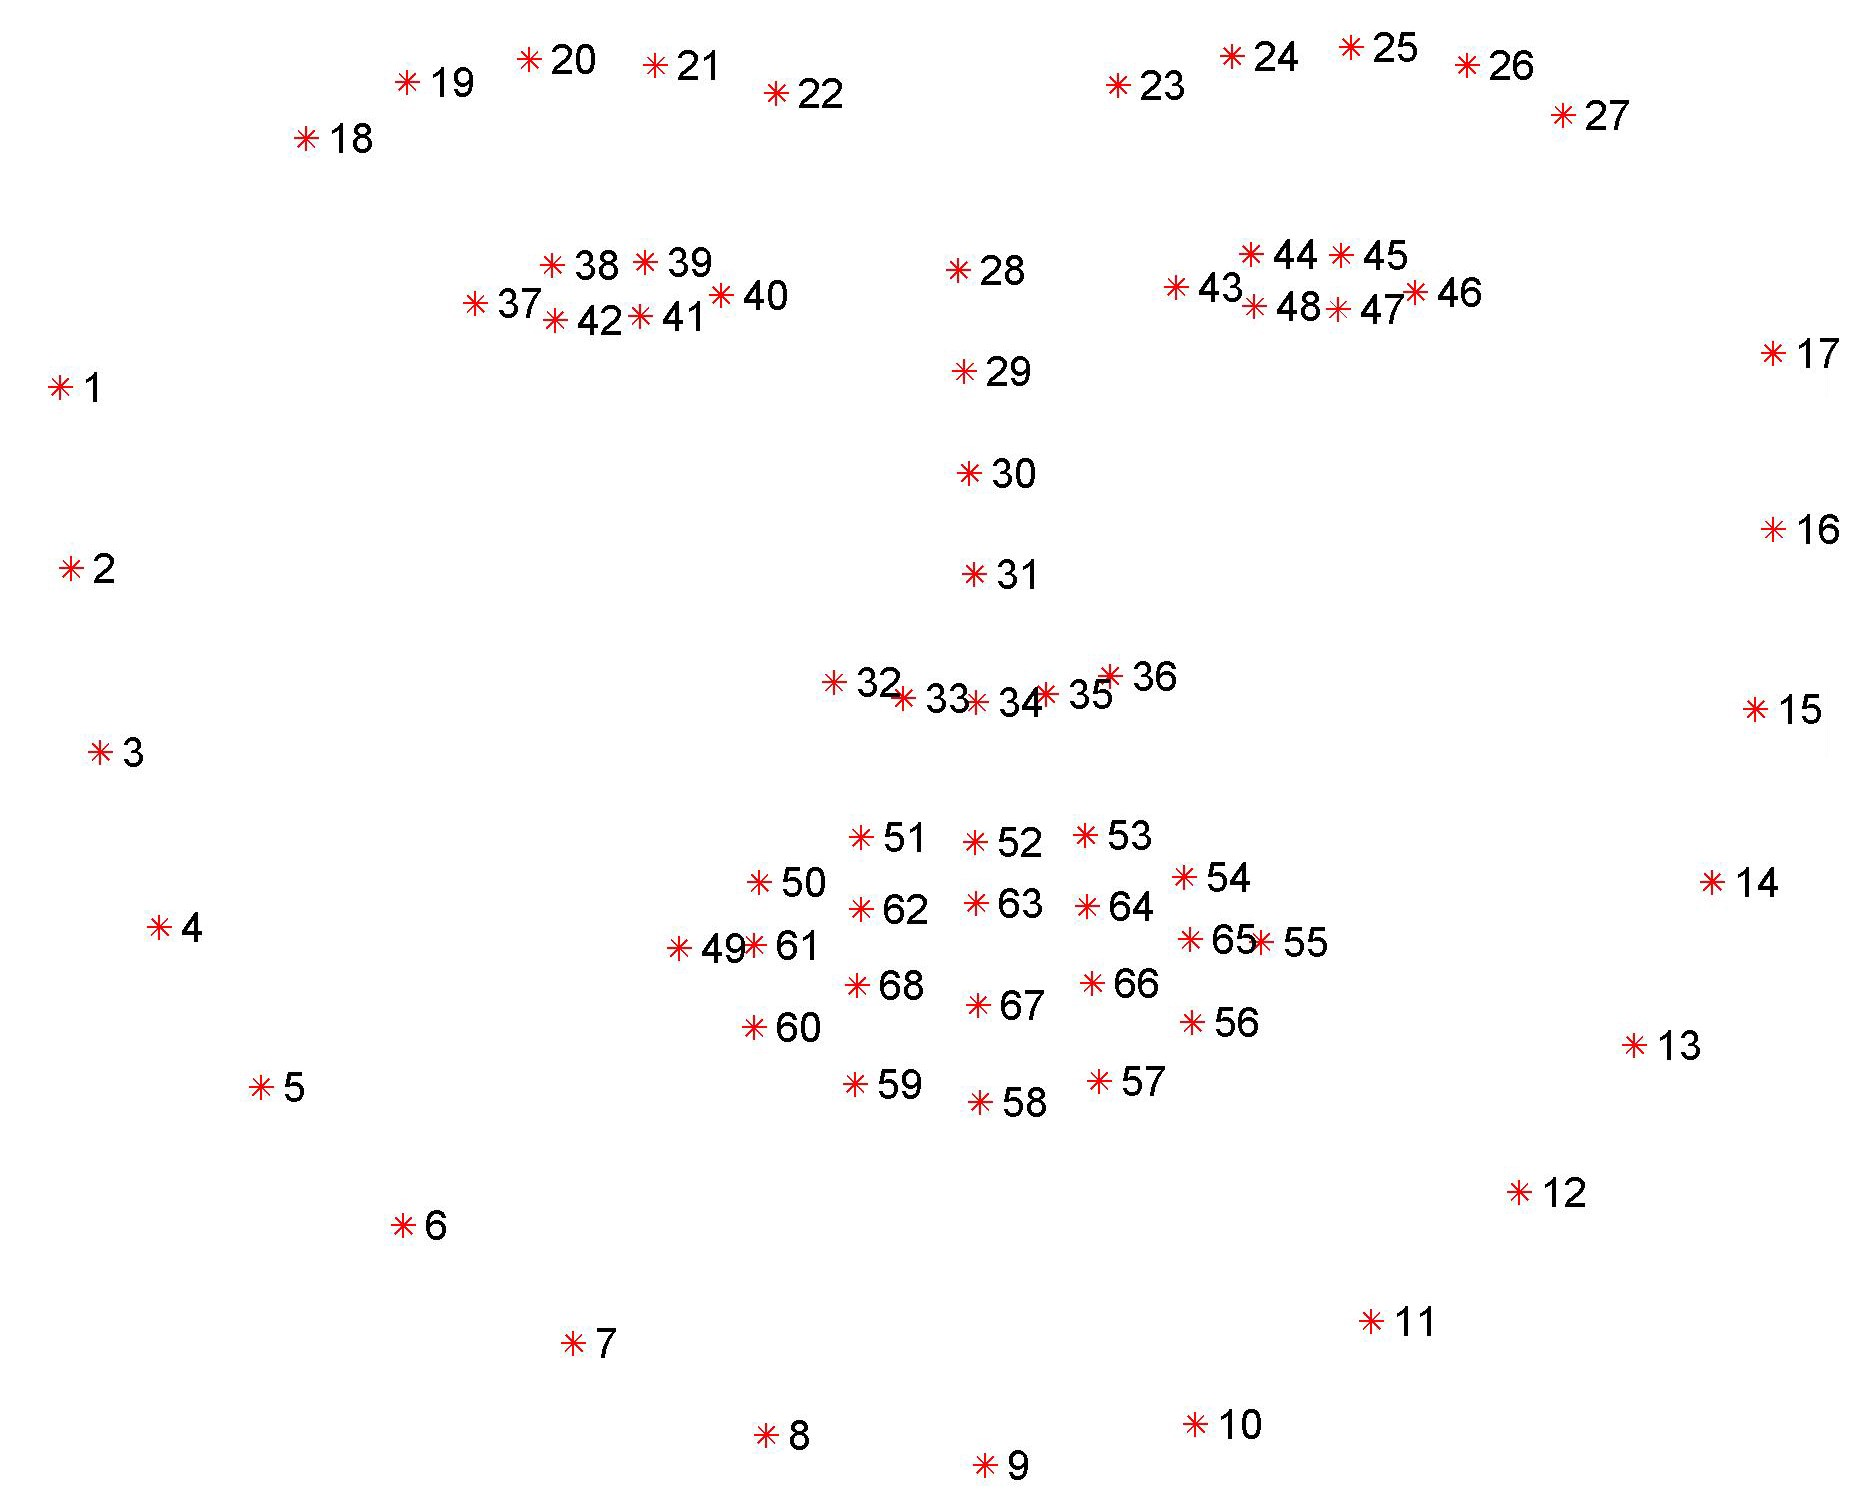

I am using [Face Recognition Library](https://github.com/ageitgey/face_recognition) to detect face. This library is built on [dlib](http://dlib.net/)'s pretrain model.

In [2]:
# import libraries
import face_recognition as fr
import PIL
import cv2
import time
import numpy as np
import os, sys
import pandas as pd

We can run deep learning algorithm to recognize face from live video and mark attendance based on face recognition.
First we need dataset of images for all student in class to do face recodntition attendance. To create data set we need to add one image (in '.jpg' format) of each student in class with image name as 'FirstName LastName'. This name will be used to mark attendance in register. 

In [3]:
# check the dataset
image_path = '../images/'
student_list = os.listdir(image_path)
print(student_list)

['andrew ng.jpg', 'lady.jpg', 'pradip solanki.jpg']


We have student data now wee need to create attendance register to mark attendace of each student.

In [4]:
# create dataframe to keep track of attendace
attendance_register = pd.DataFrame()
# add name of each student from image name
attendance_register['image_name'] = student_list
# get name of students by removing last 4 character from image name ('.jpg')
attendance_register['Name'] = attendance_register['image_name'].apply(lambda x: x[:-4])
# initially mark every student as absent
attendance_register['Attendance'] = 'A'
# record session time for each student
attendance_register['Session Time'] = 0
# remove unwanted column
attendance_register.drop(columns=['image_name'],inplace=True)
# check the register
attendance_register

,Name,Attendance,Session Time
0,andrew ng,A,0
1,lady,A,0
2,pradip solanki,A,0


We have dataset now we can encode each student image with 128-dimension face encoding. This encoding will be used to compare encoding from live video feed to mark attendance.

In [5]:
class_enc = []
# create a list of face encoding from each student image
for student in student_list:
    # load an image file into a numpy array
    image = fr.load_image_file(image_path + student)
    # given an image, face_encodings method returns the 128-dimension face encoding for each face in the image.
    encoding = fr.face_encodings(image)[0]  # extract first encoding from the list
    # add each encoding into the list
    class_enc.append(encoding)

Now we can build real time face recognition attendace system. We need to capture frames from webcam and treat each frame as individual image to run face recognition on it. We can encode each frame with face encoding and if encoding can be done then we can compare this encoding with our class encoding and find the minimum distance between images to determine match. Once we have match from live video we can mark attendance to the matching image of the student.

In [6]:
def match_encoding(ref_enc, test_image, tolerance):
    '''
    Given an image performs face encoding and compare it with given list of encodings.
    If distance between images is less than tolerance then index of encoding from the list that matched
    with the test image is returned.
    '''
    index = -1
    try:
        # encode the test image
        enc_test = fr.face_encodings(test_image)[0]  # extract first encoding from the list
        # compare a list of face encodings against a test encoding to see if they match
        # euclidean distance for each face encoding is calculated and compared with tolerance value
        # tolerance is the distance between faces to consider it a match
        result = fr.compare_faces(ref_enc,enc_test,tolerance)
        # get the index of match
        index = np.argmax(result)
    except:
        # face encoding failed, there is no face present in image
        pass
    return index

In [7]:
def mark_attendance(register, index, time):
    # mark attendance in register to given index
    register.iloc[[index],[1]] = 'P'
    # add session time
    register.iloc[[index],[2]] += time    

## Drowsiness detector

Drowsiness is described as unusual sleepiness. Drowsiness is a factor for student that are falling behind in there study. We can use deep learning algorithum to detect drowsiness and sound alarm to aleart the drowsy student. This will help them pay more attention in class.

To detect drowsiness we apply facial landmark detection and extract the eye regions. Once we have the eye regions, we can compute the eye aspect ratio to determine if the eyes are closed. If eyes have been closed for a sufficiently long time, we will sound an alarm to wake up the student.

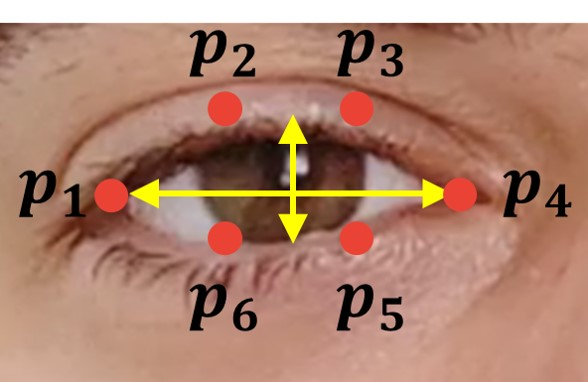

In [8]:
def ratio(points):
    # from list of tuples calculate aspect ratio
    # initialize default values for extreme points
    left = 1000000
    right = 0
    up = 1000000
    down = 0
    # iterate over all points to find extreme points
    for p in points:
        if p[0] < left:
            left = p[0]
        if p[0] > right:
            right = p[0]
        if p[1] < up:
            up = p[1]
        if p[1] > down:
            down = p[1]
    # calculate aspect ratio
    ratio = (down - up) / (right - left)
    return ratio

In [39]:
def calculate_ear(image):
    '''
    From given image, detect facial features and extracts eyes.
    If eye feature is extracted calculate eye aspect ratio and return the average of ratio from both eyes.
    Argument:
        image: input image 
    returns:
        ear: float indicating average eye aspect ratio
    '''
    ear = 0.5 # default start ratio
    try:
        # get facial landmarks as dictionary
        landmarks = fr.face_landmarks(image)
        # extract left and right eye points from landmarks
        left_eye_points = landmarks[0]['left_eye']
        right_eye_points = landmarks[0]['right_eye']
        ear_left = ratio(left_eye_points)
        ear_right = ratio(right_eye_points)
        ear = (ear_left + ear_right)/2
    except:
        # unable to load facial features
        pass
    return ear

In [18]:
def drowsiness_alert(image):
    '''Adds text in image for drowsiness alert'''
    return cv2.putText(image,text='Drowsiness Alert!',org=(10,30),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=1,color=(0,0,255),thickness=2)

In [19]:
def not_attentive(image):
    '''Adds text in image for attention alert'''
    return cv2.putText(image,text='Not attentive!',org=(10,20),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=0.5,color=(0,0,0),thickness=1)

In [20]:
def attendance_notification(image,name):
    '''Adds text in image to indicate attendance is marked'''
    msg = 'Welcome ' + name + ' your attendance is marked.'
    return cv2.putText(image,text=msg,org=(10,20),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=0.5,color=(0,255,0),thickness=1)

In [21]:
def run_live_monitoring(register, ref_enc, tolerance=0.6, ear_threshold=0.2):
    # converrt frame rate to time of sleep
    time_delta = 1/frame_rate
    red = (0,0,255)
    green = (0,255,0)
    black = (0,0,0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    # capture frames from webcam
    camera = cv2.VideoCapture(0)
    # read first frame
    webcam, frame = camera.read()
    # loop till camera is open
    while webcam:
        # pause current video frames for processing
#         time.sleep(time_delta)
        # get index of match
#         frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        index = match_encoding(ref_enc, frame, tolerance)
        # add time to session time of matching student
        if index != -1:
            mark_attendance(register, index, time_delta)
        
        ear = calculate_ear(frame)
        print(ear)
        
        output = not_attentive(frame)
        # show output image on a window
        cv2.imshow('LIVE CLASS MONITORING SYSTEM', output)
        # read next frame
        webcam, frame = camera.read()
        # press 'q' to exit the window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    camera.release()
    cv2.destroyAllWindows()

In [41]:
run_live_monitoring(attendance_register, class_enc, 0.6)

0.36585365853658536 0.35714285714285715
0.3614982578397212
0.3 0.3076923076923077
0.3038461538461539
0.3 0.28205128205128205
0.291025641025641
0.34210526315789475 0.2894736842105263
0.3157894736842105
0.325 0.35
0.3375
0.35 0.3170731707317073
0.3335365853658536
0.3076923076923077 0.275
0.29134615384615387
0.4418604651162791 0.4666666666666667
0.4542635658914729
0.4444444444444444 0.46808510638297873
0.4562647754137116
0.4583333333333333 0.46938775510204084
0.4638605442176871
0.41304347826086957 0.4166666666666667
0.4148550724637681
0.3829787234042553 0.40425531914893614
0.3936170212765957
0.1388888888888889 0.11428571428571428
0.12658730158730158
0.15384615384615385 0.13157894736842105
0.14271255060728744
0.13513513513513514 0.1388888888888889
0.13701201201201202
0.16666666666666666 0.10810810810810811
0.13738738738738737
0.16216216216216217 0.13513513513513514
0.14864864864864866


In [39]:
attendance_register

,Name,Attendance,Session Time
0,andrew ng,A,0.0
1,lady,A,0.0
2,pradip solanki,P,10.9
